# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [60]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# First income Groups and mapping offers.

In [61]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [62]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [67]:
# A list to be used for mapping
Offers =  []


In [68]:
def Offers_Mapper(offer_vlaue):
    """
    INPUT offer_value: a dictionay that contains the offer ID
    
    No OUTPUT 
    
    checks offerid and appends the offer name
    
    """
    
    
    if offer_vlaue ==  {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}:
        Offers.append('offer 1')
    
    
    if offer_vlaue ==  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}:
        Offers.append('offer 2')
    
    
    
    if offer_vlaue ==  {'offer id': '3f207df678b143eea3cee63160fa8bed'}:
        Offers.append('offer 3')
    
    if offer_vlaue ==  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}:
        Offers.append('offer 4')

    if offer_vlaue ==  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}:
        Offers.append('offer 5')
    
    
    if offer_vlaue ==  {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}:
        Offers.append('offer 6')
        
    
    
    if offer_vlaue ==  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}:
        Offers.append('offer 7')
        

    
   
    if offer_vlaue ==  {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}:
        Offers.append('offer 8')
    
    
    if offer_vlaue ==  {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}:
        Offers.append('offer 9')
    
    
    
    if offer_vlaue ==  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}:
        Offers.append('offer 10')
    return 
    

In [69]:
transcript.value.map(Offers_Mapper)

0         None
1         None
2         None
3         None
4         None
5         None
6         None
7         None
8         None
9         None
10        None
11        None
12        None
13        None
14        None
15        None
16        None
17        None
18        None
19        None
20        None
21        None
22        None
23        None
24        None
25        None
26        None
27        None
28        None
29        None
          ... 
306504    None
306505    None
306506    None
306507    None
306508    None
306509    None
306510    None
306511    None
306512    None
306513    None
306514    None
306515    None
306516    None
306517    None
306518    None
306519    None
306520    None
306521    None
306522    None
306523    None
306524    None
306525    None
306526    None
306527    None
306528    None
306529    None
306530    None
306531    None
306532    None
306533    None
Name: value, Length: 306534, dtype: object

In [70]:
transcript_cleaned = transcript
transcript_cleaned['Offers_type'] = Offers

ValueError: Length of values does not match length of index

In [58]:
np.sum(transcript_cleaned.isnull())

event     0
person    0
time      0
value     0
dtype: int64

In [59]:
np.unique(Offers)

array(['offer 1', 'offer 10', 'offer 2', 'offer 3', 'offer 4', 'offer 5',
       'offer 6', 'offer 7', 'offer 8', 'offer 9'], 
      dtype='<U8')

In [51]:
transcript_cleaned.shape

(306534, 4)

In [27]:
if {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'} == {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}:
    print('duh')

duh


In [11]:
transcript.value.map(Offers_Mapper)

KeyError: 'offer id'

In [6]:
transcript['offers'] = Offers

ValueError: Length of values does not match length of index

,event,person,time,value,offers
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},offer 4
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},offer 5
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},offer 10
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},offer 7
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},offer 2


In [ ]:
Cleaned_transcript =

In [2]:
portfolio.shape

(10, 6)

In [15]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [3]:
profile.shape

(17000, 5)

In [ ]:
transcript.plot.bar()

KeyboardInterrupt: 

In [ ]:
plt.pcolor(transcript)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5eb9fdf1d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f5ebb0e8cc0>]], dtype=object)

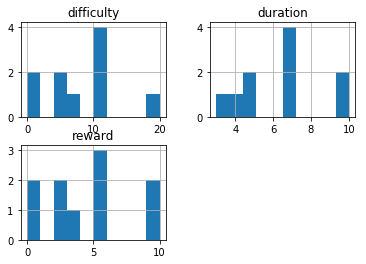

In [4]:
portfolio.hist()

In [5]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [6]:
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [7]:
portfolio.shape[0]

10

In [8]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [9]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


transcript

In [10]:
def total_count(df, col1, col2, look_for):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    #loop through list of ed types
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the ed type is in the row add 1
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df


In [11]:
portfolio.channels.str.split(',')

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
Name: channels, dtype: float64

In [12]:
profile.income.sort_values().unique()

array([  30000.,   31000.,   32000.,   33000.,   34000.,   35000.,
         36000.,   37000.,   38000.,   39000.,   40000.,   41000.,
         42000.,   43000.,   44000.,   45000.,   46000.,   47000.,
         48000.,   49000.,   50000.,   51000.,   52000.,   53000.,
         54000.,   55000.,   56000.,   57000.,   58000.,   59000.,
         60000.,   61000.,   62000.,   63000.,   64000.,   65000.,
         66000.,   67000.,   68000.,   69000.,   70000.,   71000.,
         72000.,   73000.,   74000.,   75000.,   76000.,   77000.,
         78000.,   79000.,   80000.,   81000.,   82000.,   83000.,
         84000.,   85000.,   86000.,   87000.,   88000.,   89000.,
         90000.,   91000.,   92000.,   93000.,   94000.,   95000.,
         96000.,   97000.,   98000.,   99000.,  100000.,  101000.,
        102000.,  103000.,  104000.,  105000.,  106000.,  107000.,
        108000.,  109000.,  110000.,  111000.,  112000.,  113000.,
        114000.,  115000.,  116000.,  117000.,  118000.,  1190

In [12]:
df = profile[profile['income'] >40000 ] 
df = df[df['income'] < 50000]
df

,age,became_member_on,gender,id,income
14,26,20140213,M,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0
18,57,20171231,M,6445de3b47274c759400cd68131d91b4,42000.0
29,59,20150121,M,ebe7ef46ea6f4963a7dd49f501b26779,41000.0
49,41,20150921,F,3f89b8f80ebc4f94b7074f28071aa8d4,41000.0
50,79,20150415,F,a3b9b4bf115e4564933ea2e4bc936843,48000.0
59,45,20171006,M,186d6403f5824c739555b732f4af3f16,48000.0
64,76,20180314,F,ab66a363907e43e9a7cd535f1578245b,47000.0
78,30,20171202,M,faf74115a43b4f718f4d4c0de116ee8a,41000.0
81,51,20151231,M,f44b44b53c0548d5b27c812fda4c358a,41000.0
102,66,20160124,M,21c73d53e2a74bb1b4dc172bff2b1aad,49000.0


In [13]:
profile.shape

(17000, 5)

In [24]:
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'} == {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}

True

In [14]:
# make income groups
df = profile[profile['income'] >40000 ] 
df = df[df['income'] < 50000]
df

,age,became_member_on,gender,id,income
14,26,20140213,M,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0
18,57,20171231,M,6445de3b47274c759400cd68131d91b4,42000.0
29,59,20150121,M,ebe7ef46ea6f4963a7dd49f501b26779,41000.0
49,41,20150921,F,3f89b8f80ebc4f94b7074f28071aa8d4,41000.0
50,79,20150415,F,a3b9b4bf115e4564933ea2e4bc936843,48000.0
59,45,20171006,M,186d6403f5824c739555b732f4af3f16,48000.0
64,76,20180314,F,ab66a363907e43e9a7cd535f1578245b,47000.0
78,30,20171202,M,faf74115a43b4f718f4d4c0de116ee8a,41000.0
81,51,20151231,M,f44b44b53c0548d5b27c812fda4c358a,41000.0
102,66,20160124,M,21c73d53e2a74bb1b4dc172bff2b1aad,49000.0


In [15]:
#put them in a list
ids = df.id.tolist()

In [16]:
#check offers sent to them
df_40to50 =transcript[transcript['person'].isin(ids)]

In [17]:
df_40to50.head()

,event,person,time,value
18,offer received,ebe7ef46ea6f4963a7dd49f501b26779,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
32,offer received,a3b9b4bf115e4564933ea2e4bc936843,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
42,offer received,e8fe7ffcf1634713a819d48447737c90,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
70,offer received,21c73d53e2a74bb1b4dc172bff2b1aad,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
81,offer received,52f0bd64403f4958ab8fe9a6947c13c3,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}


In [22]:
df_40to50.value.apply(Offers_Mapper)

KeyError: 'offer id'

In [18]:
df_40to50.groupby('person').event.count()

person
005500a7188546ff8a767329a2f7c76a    13
00857b24b13f4fe0ad17b605f00357f5    12
008d7088107b468893889da0ede0df5c    18
00c32a104f0c4065b5b552895fb22e34     9
00c91f31f5f74e769fa7a359b63e1a9f    26
00e9f403afa641889cd034ee7c7ca6e9    29
01784d3e205548a594ba3fcdbdaaf17d    23
01873cc8de734961949af7c04b2e9872    28
01e97a4633bf4963838a4aa9ed1dce3e    17
020be8b0fafa446ebcce6449b20bc92c    19
0222d267445f4f078bc325224e471766    18
02557fafcf334c30a22c312c5647f71a    14
02b5aa5725f94bcb94ca58208015b7bc    21
02c8c9806a8c44f792a218fb2e8756b3    14
02f638a6c98241c98b24a06ca489aac0    13
03374e3f14564b36a7138154ed8c194a    14
034ce97360c6485ab990d903343f9f08    15
03637e48ffda4bf9b73b079d03c0bbe3    23
036f1e5cca91478685c8cef24cc8b076    13
03e866224ec641c58bc93a69be00de9c    16
03fbbeecf81b468684b50dbe63ac4587    13
03ff3cf4aec84162be697c28346bdd5a    18
0414fcebbd7f4a19bca352622b1c84e2    18
04837bcb97e241769a747cd71c50fe2f     7
04c143b7068e4c32995e1031173bea43    10
04cfc7c495c1419f9a